In [1]:
import numpy as np
import onnxruntime
from PIL import Image
import json
import time

## You will need to Install onnxruntime

# If you don't have a GPU install cpu version
# pip install onnxruntime

# If you have a GPU install gpu version
# pip install onnxruntime-gpu

# Make sure you install the correct version for your version of CUDA!
# Also check dependencies!
# https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html
# EG for CUDA version 12.2 use 
# pip install onnxruntime-gpu==1.17

# NOTE Pytorch has it's own cuDNN that gets installed with torch
# If you want to use other applications that need cuDNNm like onnxruntime-gpu (without having to import torch)
# You need to install cuDNN separately (it doesn't come with NVIDIA Toolkit)
# NOTE: at time of writing only cuDNN 8.X versions are supported!!
# https://docs.nvidia.com/deeplearning/cudnn/archives/cudnn-890/install-guide/index.html

# Create an ONNX Runtime inference session with GPU support
ort_session = onnxruntime.InferenceSession("./efficientnet_b1.onnx", 
                                           providers=['CUDAExecutionProvider'])

with open("../../data/imagenet_classes.json", "r") as file:
    img_net_classes = json.load(file)

In [2]:
def crop_resize(image, new_size):
    # Get the dimensions of the original image
    width, height = image.size

    # Calculate the size of the square crop
    min_dim = min(width, height)

    # Calculate coordinates for the center crop
    left = (width - min_dim) // 2
    upper = (height - min_dim) // 2
    right = left + min_dim
    lower = upper + min_dim

    # Crop the image to a square
    square_image = image.crop((left, upper, right, lower))

    # Resize the image to the specified size
    resized_image = square_image.resize((new_size, new_size))

    return resized_image

In [3]:
def image_normalise_reshape(image, mean, std):
    h, w, c = image.shape    
    image = image.transpose((2, 0, 1))/255
    
    np_means = np.array(mean).reshape(c, 1, 1)
    np_stds = np.array(std).reshape(c, 1, 1)
    
    norm_image = (image - np_means)/(np_stds + 1e-6)
    
    return np.expand_dims(norm_image, 0).astype(np.float32)
    

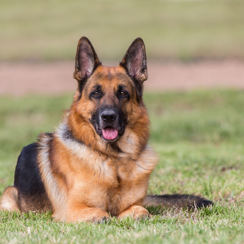

In [4]:
test_image = crop_resize(Image.open("../../data/dog.jpg"), 244)
test_image

In [8]:
np_image = np.array(test_image)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
norm_image = image_normalise_reshape(np_image, mean, std)
# Should also work with batch of images!
# norm_image_batch = np.concatenate((norm_image, norm_image), 0)

# Prepare the inputs for ONNX Runtime
onnxruntime_input = {ort_session.get_inputs()[0].name: norm_image}

start_time = time.time()
# Run inference
onnxruntime_outputs = ort_session.run(None, onnxruntime_input)
end_time = time.time()

# Print the outputs
print("ONNX Runtime outputs:")
for output in onnxruntime_outputs:
    class_index = np.argmax(output)
    print("Class index:", class_index)
    print("Class Label:", img_net_classes[str(class_index)])
    
print("Time to run: %.4fs" % (end_time - start_time))

ONNX Runtime outputs:
Class index: 235
Class Label: German shepherd, German shepherd dog, German police dog, alsatian
Time to run: 0.0038s
